In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
from IPython.display import clear_output
import random
from random import sample

In [3]:
start_token = " "
end_token = "."

def read_names(path_to_file):
    global start_token
    
    with open(path_to_file) as f:
        names = f.read()[:-1].split('\n')
        #names = [start_token + line for line in names]
        names = [f'{start_token}{line}{end_token}' for line in names]
        return names

In [4]:
try:
    names = read_names('../datasets/names_dataset/names')
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/names_dataset/names -nc -O names
    names = read_names('./names')
    
try:
    names_ru = read_names('../datasets/names_dataset/names_ru')
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/names_dataset/names_ru -nc -O names_ru
    names_ru = read_names('./names_ru')

File ‘names’ already there; not retrieving.
File ‘names_ru’ already there; not retrieving.


In [5]:
print ('n samples = ',len(names_ru))
for idx in np.arange(0, len(names), 1000):
    print(names[idx], names_ru[idx])

assert len(names) == len(names_ru), 'Wrong lengths'

n samples =  7944
 Abagael.  Абагаел.
 Claresta.  Слареста.
 Glory.  Глорй.
 Liliane.  Лилиане.
 Prissie.  Приссие.
 Geeta.  Геета.
 Giovanne.  Гиованне.
 Piggy.  Пиггй.


In [8]:
import re

In [12]:
t = names[0]
print(t)
re.sub('\.|\s','',t)

 Abagael.


'Abagael'

max length = 17


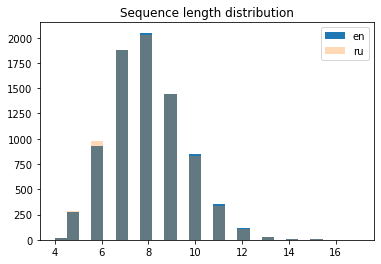

In [18]:
# length of sequence including sos and eos tikens
MAX_LENGTH = max(map(len, names))

print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25, label='en');

plt.title('Sequence length distribution')
plt.hist(list(map(len, names_ru)),bins=25, alpha=0.3, label='ru');
plt.legend()
plt.show()

In [19]:
all_tokens_set_en = set()
for name in names:
    all_tokens_set_en.update(set(name))

tokens_en = list(all_tokens_set_en)# <list of all unique characters in the dataset>

num_tokens_en = len(tokens_en)
print (f'num_tokens = {num_tokens_en}')

assert 50 < num_tokens_en < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens = 56


In [20]:
all_tokens_set_ru = set()
for name in names_ru:
    all_tokens_set_ru.update(set(name))

tokens_ru = list(all_tokens_set_ru)# <list of all unique characters in the dataset>

num_tokens_ru = len(tokens_ru)
print (f'num_tokens = {num_tokens_ru}')

assert 50 < num_tokens_ru < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens = 55


In [21]:
token_to_id_en = {
    token: idx for idx, token in enumerate(tokens_en)
}

token_to_id_ru = {
    token: idx for idx, token in enumerate(tokens_ru)
}

In [22]:
assert len(tokens_ru) == len(token_to_id_ru), "dictionaries must have same size"

for i in range(num_tokens_ru):
    assert token_to_id_ru[tokens_ru[i]] == i, "token identifier must be it's position in tokens list"

for i in range(num_tokens_en):
    assert token_to_id_en[tokens_en[i]] == i, "token identifier must be it's position in tokens list"
    
print("Seems alright!")

Seems alright!


In [23]:
def to_matrix(names, token_to_id, max_len=None, pad=None, dtype='int32', batch_first=False):
    """Casts a list of names into rnn-digestable matrix"""
    pad = token_to_id[' ']
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [28]:
example = to_matrix(names[:3], token_to_id_en)
print(example,'\n', example.shape)
del example

[[11 11 11]
 [45 45 45]
 [25 25 25]
 [52 52 25]
 [15 15 32]
 [52 52 35]
 [32  5 11]
 [54 54 11]
 [35 35 11]] 
 (9, 3)


In [29]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Teacher forcing model with LSTM and dropout

In [30]:
class Encoder(nn.Module):
    def __init__(self, num_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.num_tokens = num_tokens
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(num_tokens, emb_dim)# <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size= hid_dim,
                           num_layers = n_layers, dropout = dropout) # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(dropout) # <YOUR CODE HERE>
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        # <YOUR CODE HERE>
        
        #embedded = [src sent len, batch size, emb dim]
        embedded = self.embedding(src) 
        
        embedded = self.dropout(embedded) 
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        
        output, (hidden, cell) = self.rnn(embedded) # <YOUR CODE HERE> 
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        # Note: hidden - hidden state from the last state for each batch
        # element 
        shp = [self.n_layers, src.shape[1], self.hid_dim]
        assert list(hidden.size()) == shp, 'Wrong hidden dim'
        assert list(cell.size()) == shp, 'Wrong cell dim'
        return hidden, cell

In [31]:
# check encoder forward pass:
t = to_matrix(sample(names, 32), token_to_id_en, max_len=MAX_LENGTH)
t = torch.LongTensor(t)
print(t.shape) 

tencoder = Encoder(
    num_tokens = len(token_to_id_en),
    emb_dim = 64, hid_dim = 128,
    n_layers = 2, dropout = 0.5)

tenc_h, tenc_c  = tencoder.forward(t)

print(tenc_h.size(), tenc_c.size())

torch.Size([17, 32])
torch.Size([2, 32, 128]) torch.Size([2, 32, 128])


In [32]:
class Decoder(nn.Module):
    def __init__(self, num_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.num_tokens = num_tokens
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(num_tokens, emb_dim)# <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size= hid_dim,
                           num_layers = n_layers, dropout= dropout) # <YOUR CODE HERE>
        
        # Note:
        # aditional linear layer to convert rnn outputputs hid_dim to 
        # probs of tokens dim - voc size
        self.out = nn.Linear(hid_dim, num_tokens) # <YOUR CODE HERE>
         
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        # add first dim = 1: 
        trg = trg.unsqueeze(0)
        
        #input = [1, batch size]
        
        # Compute an embedding from the input data and apply dropout to it
        embedded = self.embedding(trg) # <YOUR CODE HERE>
        embedded = self.dropout(embedded)
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))# <YOUR CODE HERE>
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        # Note: we do not need softmax because we will predict
        # the most likely token using argmax
        
        return prediction, hidden, cell

In [33]:
# check forward pass of decoder
# we take slice of batch because will use teacher forcing

t = to_matrix(sample(names_ru, 32), token_to_id_ru, max_len=MAX_LENGTH)
t = torch.LongTensor(t)[0,:]
print(t.shape) 

tdecoder = Decoder(
    num_tokens = len(token_to_id_ru),
    emb_dim = 64, hid_dim = 128,
    n_layers = 2, dropout = 0.5
)

tdec_res = tdecoder.forward(t, tenc_h, tenc_c)
print(tdec_res[0].size(), tdec_res[1].size(), tdec_res[2].size())

torch.Size([32])
torch.Size([32, 55]) torch.Size([2, 32, 128]) torch.Size([2, 32, 128])


In [34]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.num_tokens
        
        #tensor to store decoder outputs
        outputs = torch.zeros(
            max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input_ = trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input_, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            # get token number with highest score for every 128 rows by columns
            #top1 = output.max(1)[1]
            top1 = output.argmax(1)
            input_ = (trg[t] if teacher_force else top1)
        
        return outputs

In [37]:
# check Seq2Seq

#tencoder = Encoder()
#tdecoder = Decoder()

device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')

tmodel = Seq2Seq(tencoder, tdecoder, device)

t_src = to_matrix(sample(names, 32), token_to_id_en, max_len=MAX_LENGTH)
t_src = torch.LongTensor(t_src)

t_trg = to_matrix(sample(names_ru, 32), token_to_id_ru, max_len=MAX_LENGTH)
t_trg = torch.LongTensor(t_trg)

print(t_src.size(), t_trg.size())

res_tseq2seq = tmodel.forward(
    t_src, 
    t_trg
)

print(res_tseq2seq.size())

preds = res_tseq2seq.argmax(-1)
print(preds.size())

device: cpu
torch.Size([17, 32]) torch.Size([17, 32])
torch.Size([17, 32, 55])
torch.Size([17, 32])


## Train

In [60]:
# helper functions: 

def init_weights(m):
    # <YOUR CODE HERE>
    for p in m.parameters():
        nn.init.uniform_(p, -0.08, 0.08)
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [61]:
# train parameters: 

n_epoch = 5
batch_size = 128
emb_size_ = 128
rnn_num_units_ = 256 
n_layers_ = 1
dropout_ = 0.5

enc = Encoder(
    num_tokens = len(token_to_id_en),
    emb_dim = emb_size_, hid_dim = rnn_num_units_,
    n_layers = n_layers_, dropout = dropout_)

dec = Decoder(
    num_tokens = len(token_to_id_ru),
    emb_dim = emb_size_, hid_dim = rnn_num_units_,
    n_layers = n_layers_, dropout = dropout_)

model = Seq2Seq(enc, dec, device).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

# initialize model
model.apply(init_weights)

PAD_IDX = token_to_id_ru[' ']
#criterion = nn.NLLLoss(ignore_index= PAD_IDX)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
opt = optim.Adam(model.parameters())

loss_li = []

The model has 818,871 trainable parameters


/Users/artem/Documents/ML_projets/venvs/work_env/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch number 10/10..


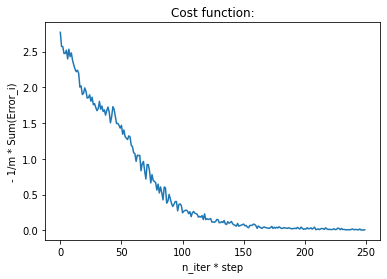

In [62]:
for epoch in range(n_epoch):
    
    for i in range(500):

        # generate batch:
        indices = np.random.choice(np.arange(len(names)), size=batch_size)

        # tokenize src batch
        batch_en = to_matrix(
            np.array(names)[indices],
            token_to_id=token_to_id_en,
            max_len=MAX_LENGTH)

        input_tensor = torch.from_numpy(batch_en).type(torch.int64)

        # tokenize trg batch
        batch_ru = to_matrix(
            np.array(names_ru)[indices],
            token_to_id=token_to_id_ru,
            max_len=MAX_LENGTH
        )

        target_tensor = torch.from_numpy(batch_ru).type(torch.int64)

        # generate preds:
        logp_seq = model(
            input_tensor, target_tensor, teacher_forcing_ratio= 0.5)
        
        preds = logp_seq[1:].view(-1, len(token_to_id_ru))
        targets = target_tensor[1:].contiguous().view(-1)
        loss = criterion(preds, targets)

        # calculate grads
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        # update grads
        opt.step()

        # zero grads
        opt.zero_grad()
        
        if (i+1) % 20 == 0:
            loss_li.append(loss.item())
    
    print(f'Epoch number {epoch + 1}/{n_epoch}..')
    plt.plot(loss_li)
    plt.title('Cost function:')
    plt.ylabel('- 1/m * Sum(Error_i)')
    plt.xlabel('n_iter * step')
    plt.show()
    clear_output(True)

# Results

In [ ]:
# text_batch_en -> encoder ->ht
# in loop put sos and ht -> decoder 
# decoder -> probs for tokens ~ new input & ht+1  -> decoder
# ...

In [72]:
def decode_tokens(x, decode_di): 
    if not isinstance(x, list):
        x = x.reshape(len(x))
    x = ''.join([decode_di.get(c) for c in x])
    x = re.sub('\.', '', x)
    return x

In [73]:
# create inverse dicts

id_to_token_en = {j:i for i,j in token_to_id_en.items()}
assert len(id_to_token_en) == len(token_to_id_en), 'Error with lengths'

id_to_token_ru = {j:i for i,j in token_to_id_ru.items()}
assert len(id_to_token_ru) == len(token_to_id_ru), 'Error with lengths'

In [88]:
def translate_one_name(model, pad_ix): 
    
    model.eval()
    
    # generate random sample: 
    indices = np.random.choice(np.arange(len(names)), size=1)
    no_eos_seq = re.sub('\.', '', names[indices[0]])
    print(f'Random name: {no_eos_seq}')
    
    # tokenize src batch
    text_batch_en = to_matrix(
        np.array(names)[indices],
        token_to_id=token_to_id_en,
        max_len=MAX_LENGTH)
    
    
    text_batch_en = torch.from_numpy(text_batch_en).type(torch.int64)
    
    with torch.no_grad():
        enc_hlast, enc_clast  = model.encoder(text_batch_en)

        input_ = np.array([pad_ix])
        input_ = torch.from_numpy(input_).type(torch.int64)

        predicted_tokens_li = [PAD_IDX]
        
        h_next = enc_hlast
        c_next = enc_clast
        
        for i in range(1, MAX_LENGTH):
            
            token_preds, h_next, c_next = model.decoder(input_, h_next, c_next)

            predicted_token = token_preds.argmax(-1).item()
            predicted_tokens_li.append(predicted_token)
        
            input_ = np.array([predicted_token])
            input_ = torch.from_numpy(input_).type(torch.int64)
            
        return predicted_tokens_li

In [117]:
preds = translate_one_name(model, PAD_IDX)
decoded = decode_tokens(preds, id_to_token_ru)
print(f'Translation: {decoded}')

Random name:  Aurea
Translation:  Ауреа


# Low teacher forcing parametr

In [119]:
# train parameters: 

n_epoch = 5
batch_size = 128
emb_size_ = 128
rnn_num_units_ = 256 
n_layers_ = 1
dropout_ = 0.5

enc = Encoder(
    num_tokens = len(token_to_id_en),
    emb_dim = emb_size_, hid_dim = rnn_num_units_,
    n_layers = n_layers_, dropout = dropout_)

dec = Decoder(
    num_tokens = len(token_to_id_ru),
    emb_dim = emb_size_, hid_dim = rnn_num_units_,
    n_layers = n_layers_, dropout = dropout_)

model2 = Seq2Seq(enc, dec, device).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

# initialize model
model2.apply(init_weights)

PAD_IDX = token_to_id_ru[' ']
#criterion = nn.NLLLoss(ignore_index= PAD_IDX)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
opt = optim.Adam(model2.parameters())

loss_li = []

The model has 818,871 trainable parameters


Epoch number 5/5..


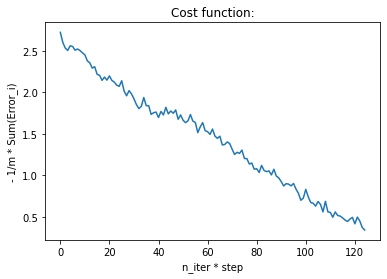

In [120]:
for epoch in range(n_epoch):
    
    for i in range(500):

        # generate batch:
        indices = np.random.choice(np.arange(len(names)), size=batch_size)

        # tokenize src batch
        batch_en = to_matrix(
            np.array(names)[indices],
            token_to_id=token_to_id_en,
            max_len=MAX_LENGTH)

        input_tensor = torch.from_numpy(batch_en).type(torch.int64)

        # tokenize trg batch
        batch_ru = to_matrix(
            np.array(names_ru)[indices],
            token_to_id=token_to_id_ru,
            max_len=MAX_LENGTH
        )

        target_tensor = torch.from_numpy(batch_ru).type(torch.int64)

        # generate preds:
        logp_seq = model2(
            input_tensor, target_tensor, teacher_forcing_ratio= 0.001)
        
        preds = logp_seq[1:].view(-1, len(token_to_id_ru))
        targets = target_tensor[1:].contiguous().view(-1)
        loss = criterion(preds, targets)

        # calculate grads
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        # update grads
        opt.step()

        # zero grads
        opt.zero_grad()
        
        if (i+1) % 20 == 0:
            loss_li.append(loss.item())
    
    print(f'Epoch number {epoch + 1}/{n_epoch}..')
    plt.plot(loss_li)
    plt.title('Cost function:')
    plt.ylabel('- 1/m * Sum(Error_i)')
    plt.xlabel('n_iter * step')
    plt.show()
    clear_output(True)

In [136]:
preds = translate_one_name(model2, PAD_IDX)
decoded = decode_tokens(preds, id_to_token_ru)
print(f'Translation: {decoded}')

Random name:  Howard
Translation:  Ховард


# High teacher forcing parametr

In [145]:
# train parameters: 

n_epoch = 5
batch_size = 128
emb_size_ = 128
rnn_num_units_ = 256 
n_layers_ = 1
dropout_ = 0.5

enc = Encoder(
    num_tokens = len(token_to_id_en),
    emb_dim = emb_size_, hid_dim = rnn_num_units_,
    n_layers = n_layers_, dropout = dropout_)

dec = Decoder(
    num_tokens = len(token_to_id_ru),
    emb_dim = emb_size_, hid_dim = rnn_num_units_,
    n_layers = n_layers_, dropout = dropout_)

model3 = Seq2Seq(enc, dec, device).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

# initialize model
model3.apply(init_weights)

PAD_IDX = token_to_id_ru[' ']
#criterion = nn.NLLLoss(ignore_index= PAD_IDX)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
opt = optim.Adam(model3.parameters())

loss_li = []

The model has 818,871 trainable parameters


Epoch number 5/5..


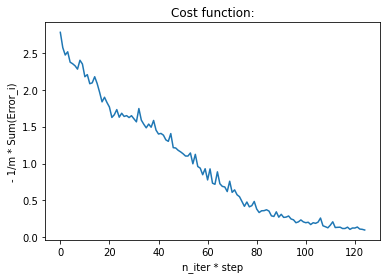

In [146]:
for epoch in range(n_epoch):
    
    for i in range(500):

        # generate batch:
        indices = np.random.choice(np.arange(len(names)), size=batch_size)

        # tokenize src batch
        batch_en = to_matrix(
            np.array(names)[indices],
            token_to_id=token_to_id_en,
            max_len=MAX_LENGTH)

        input_tensor = torch.from_numpy(batch_en).type(torch.int64)

        # tokenize trg batch
        batch_ru = to_matrix(
            np.array(names_ru)[indices],
            token_to_id=token_to_id_ru,
            max_len=MAX_LENGTH
        )

        target_tensor = torch.from_numpy(batch_ru).type(torch.int64)

        # generate preds:
        logp_seq = model3(
            input_tensor, target_tensor, teacher_forcing_ratio= 0.9)
        
        preds = logp_seq[1:].view(-1, len(token_to_id_ru))
        targets = target_tensor[1:].contiguous().view(-1)
        loss = criterion(preds, targets)

        # calculate grads
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        # update grads
        opt.step()

        # zero grads
        opt.zero_grad()
        
        if (i+1) % 20 == 0:
            loss_li.append(loss.item())
    
    print(f'Epoch number {epoch + 1}/{n_epoch}..')
    plt.plot(loss_li)
    plt.title('Cost function:')
    plt.ylabel('- 1/m * Sum(Error_i)')
    plt.xlabel('n_iter * step')
    plt.show()
    clear_output(True)

Conclusion:   
Wiht higher teacher forcing parametr model converges faster.   
Links:   
1. https://towardsdatascience.com/what-is-teacher-forcing-3da6217fed1c

In [ ]:
# train in one func: 

def train_model(model_, names_src, names_trg,
                 token_to_id_src, token_to_id_trg,
                 max_len_, n_epoch_=5, n_iter_=500, batch_size_= 32,
                 teacher_forcing_ratio_=0.5, 
               ):
    
    for epoch in range(n_epoch_):

        for i in range(n_iter_):

            # generate batch:
            indices = np.random.choice(np.arange(len(names_src)), size=batch_size_)

            # tokenize src batch
            batch_en = to_matrix(
                np.array(names_src)[indices],
                token_to_id=token_to_id_src,
                max_len=max_len_)

            input_tensor = torch.from_numpy(batch_en).type(torch.int64)

            # tokenize trg batch
            batch_ru = to_matrix(
                np.array(names_trg)[indices],
                token_to_id=token_to_id_trg,
                max_len=max_len_
            )

            target_tensor = torch.from_numpy(batch_ru).type(torch.int64)

            # generate preds:
            logp_seq = model_(
                input_tensor, target_tensor, teacher_forcing_ratio= teacher_forcing_ratio_)

            preds = logp_seq[1:].view(-1, len(token_to_id_trg))
            targets = target_tensor[1:].contiguous().view(-1)
            loss = criterion(preds, targets)

            # calculate grads
            loss.backward()

            # Let's clip the gradient
            torch.nn.utils.clip_grad_norm_(model_.parameters(), 1)

            # update grads
            opt.step()

            # zero grads
            opt.zero_grad()

            if (i+1) % 20 == 0:
                loss_li.append(loss.item())

        print(f'Epoch number {epoch + 1}/{n_epoch_}..')
        plt.plot(loss_li)
        plt.title('Cost function:')
        plt.ylabel('- 1/m * Sum(Error_i)')
        plt.xlabel('n_iter_ * step')
        plt.show()
        clear_output(True)
    return model_